In [2]:
import numpy as np
import pandas as pd
import pandahouse as ph
from scipy.stats import ttest_ind
from scipy import stats
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import time
import seaborn as sns
from statsmodels.sandbox.stats.multicomp import multipletests
import conf_secret
%matplotlib inline

In [3]:
connection_default = conf_secret.connection_default
sns.set(rc={'figure.figsize':(13.7,8.27)})

SQL queries

In [4]:
qu_real_prem_share = """
select
    region, round(avg(is_premium), 6) as real_prem_share,
    round(avg(cost_gold), 6) as real_cost_gold,
    sum(cost_gold) as sum_cost_gold
from tanks_ab
group by region
"""
big_query_prem_share = """
select
    first.account_id as account_id, region, lin_weig_prem_share,
    lin_prem_share, prem_share, avito_lin_prem_share
from (
    with (select sum(Fx)/sum(sqtr_tanks_number)
        from (
            select
                account_id, sqrt(count(tank_id)) as sqtr_tanks_number,
                sum(is_premium)/sqrt(count(tank_id)) as Fx
            from tanks_ab where region='past_ru' group by account_id)
        ) AS Ru
    select
        account_id, sum(is_premium)/sqrt(count(tank_id)) - Ru*sqrt(count(tank_id)) as lin_weig_prem_share
    from tanks_ab
    group by account_id) first
    INNER JOIN (
    with (select sum(is_premium)/count(tank_id)
        from tanks_ab where region='past_ru'
        ) AS Ru
    select account_id, sum(is_premium) - Ru*count(tank_id) as lin_prem_share
    from tanks_ab
    group by account_id) second
        ON first.account_id = second.account_id
    INNER JOIN (
    select account_id, region, avg(is_premium) as prem_share
    from tanks_ab
    group by account_id, region) third
        ON first.account_id = third.account_id
    INNER JOIN (
    with
        (select avg(inb)
        from (
            select sum(is_premium) as inb
            from tanks_ab
            where region='past_ru'
            group by account_id)
        ) AS ex,
        (select avg(ind)
        from (
            select count(tank_id) as ind
            from tanks_ab
            where region='past_ru'
            group by account_id)
        ) AS ey
    select account_id, ex/ey+(1/ey)*(sum(is_premium)-count(tank_id)*ex/ey) as avito_lin_prem_share
    from tanks_ab
    group by account_id) fourth
        ON first.account_id = fourth.account_id
order by account_id
"""
big_query_cost_gold = """
select
    first.account_id as account_id, region, lin_weig_cost_gold,
    lin_cost_gold, cost_gold, avito_lin_cost_gold
from (
    with (select sum(Fx)/sum(sqtr_tanks_number)
        from (
            select
                account_id, sqrt(count(tank_id)) as sqtr_tanks_number,
                sum(cost_gold)/sqrt(count(tank_id)) as Fx
            from tanks_ab where region='past_ru' group by account_id)
        ) AS Ru
    select
        account_id, sum(cost_gold)/sqrt(count(tank_id)) - Ru*sqrt(count(tank_id)) as lin_weig_cost_gold
    from tanks_ab
    group by account_id) first
    INNER JOIN (
    with (select sum(cost_gold)/count(tank_id)
        from tanks_ab where region='past_ru'
        ) AS Ru
    select account_id, sum(cost_gold) - Ru*count(tank_id) as lin_cost_gold
    from tanks_ab
    group by account_id) second
        ON first.account_id = second.account_id
    INNER JOIN (
    select account_id, region, avg(cost_gold) as cost_gold
    from tanks_ab
    group by account_id, region) third
        ON first.account_id = third.account_id
    INNER JOIN (
    with
        (select avg(inb)
        from (
            select sum(cost_gold) as inb
            from tanks_ab
            where region='past_ru'
            group by account_id)
        ) AS ex,
        (select avg(ind)
        from (
            select count(tank_id) as ind
            from tanks_ab
            where region='past_ru'
            group by account_id)
        ) AS ey
    select account_id, ex/ey+(1/ey)*(sum(cost_gold)-count(tank_id)*ex/ey) as avito_lin_cost_gold
    from tanks_ab
    group by account_id) fourth
        ON first.account_id = fourth.account_id
order by account_id
"""

In [5]:
df = ph.read_clickhouse(query=qu_real_prem_share, connection=connection_default)
df_big_prem_share = ph.read_clickhouse(query=big_query_prem_share, connection=connection_default)
time.sleep(1)
df_big_cost_gold = ph.read_clickhouse(query=big_query_cost_gold, connection=connection_default)

РУ регион отсает в денежных показателях. Интересно, что ру игроки, вкладывавшие в среднем больше денег в игру, решили перенести аккаунты на евро сервер, а не оставаться в ответвлении проекта на локальном сервере

In [6]:
df

,region,real_prem_share,real_cost_gold,sum_cost_gold
0,ru,0.159506,579.734878,10361340593
1,eu,0.257271,760.160364,23556667287
2,past_ru,0.257985,822.256542,38758463219


При курсе 250 голды=1 USD (официальный), на продажах прем танков компания Wargaming заработала 290.7 млн usd

In [7]:
sum(df.sum_cost_gold)/250

290705884.396

In [8]:
df_big_prem_share

,account_id,region,lin_weig_prem_share,lin_prem_share,prem_share,avito_lin_prem_share
0,100000181,ru,-1.334924,-22.950798,0.150235,0.025987
1,100000350,ru,-0.361763,-5.314467,0.205882,0.204264
2,100000373,ru,0.687598,6.434947,0.290816,0.323033
3,100000394,ru,-0.871021,-4.965594,0.074074,0.207790
4,100000415,ru,-1.108102,-10.574918,0.111111,0.151088
...,...,...,...,...,...,...
1290607,599999866,eu,-1.063471,-5.965594,0.037037,0.197682
1290608,599999872,past_ru,0.231124,0.653594,0.264151,0.264592
1290609,599999887,eu,-1.355819,-11.479098,0.066667,0.141948
1290610,599999945,eu,-0.607210,-4.867308,0.152174,0.208784


In [9]:
def boot_power(data, metric_index=[2, None],
               group_tags={'c': 'past_ru', 't1': 'eu', 't2': 'ru', 'column': 'region'},
               bootstraps=2000, sample_size=2000, alpha=0.05):
    
    metrics = list(data.columns)[metric_index[0]:metric_index[1]]
    control = data[data[group_tags['column']]==group_tags['c']][metrics]
    treatment_1 = data[data[group_tags['column']]==group_tags['t1']][metrics]
    treatment_2 = data[data[group_tags['column']]==group_tags['t2']][metrics]
    
    res_sign = dict.fromkeys(list(control.columns), np.array([]))
    res_power_c_t1 = dict.fromkeys(list(control.columns), np.array([]))
    res_power_c_t2 = dict.fromkeys(list(control.columns), np.array([]))
    
    for _ in tqdm(range(bootstraps)):
    
        np.random.seed(_)

    # get control dataset
        control_1 = control.sample(sample_size)
        control_2 = control.sample(sample_size)
    
    # get treatment dataset
        treat_1 = treatment_1.sample(sample_size)
        treat_2 = treatment_2.sample(sample_size)
    
        for metric in metrics:
            res_sign[metric] = np.append(res_sign[metric],
                stats.ttest_ind(control_1[metric], control_2[metric], equal_var = False)[1])
            res_power_c_t1[metric] = np.append(res_power_c_t1[metric],
                stats.ttest_ind(control_1[metric], treat_1[metric], equal_var = False)[1])
            res_power_c_t2[metric] = np.append(res_power_c_t2[metric],
                stats.ttest_ind(control_1[metric], treat_2[metric], equal_var = False)[1])
    
    #for res in [res_sign, res_power_c_t1, res_power_c_t2]:
        #for key, value in res.items():
            #res[key] = sum(value <alpha) / bootstraps
    
    res_sign['title'] = group_tags['c']+'_significance'
    res_power_c_t1['title'] = group_tags['c']+'_'+group_tags['t1']+'_power'
    res_power_c_t2['title'] = group_tags['c']+'_'+group_tags['t2']+'_power'
    
    df = pd.DataFrame([res_sign, res_power_c_t1, res_power_c_t2])
    
    return df

In [10]:
df_prem_share_stats, df_cost_gold_stats = boot_power(df_big_prem_share), boot_power(df_big_cost_gold)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:57<00:00, 34.75it/s]


In [11]:
def plot_pvalue_distribution(df):
    X = np.linspace(0, 1, 2000)
    for index, row in df.iterrows():
        Y = [np.mean(row[0] < x) for x in X]
        plt.plot(X, Y, label=row['title'])

    plt.plot([0, 1], [0, 1], '--k', alpha=0.8)
    plt.title(df.columns[0], size=16)
    plt.xlabel('p-value', size=12)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()

Так как отношение количества прем танков к кол-ву всех танков является Ratio-метрикой (в числителе и знаменателе стоит случайная величина, суммируемая по пользователю), то вообще обычный t-test нельзя применять, так как дисперсия оценивается неправильно из-за зависимости случайных величин (от пользователя). Чтобы избавться от этого, можно попробовать сначала взять среднее для каждого пользователя, метрика в таком случае будет среднее средних. Коллеги из Яндекса утверждают, что при таком подходе не всегда сохраняется направленность метрики - то есть настоящее среднее вырастет, а среднее средних упадет. Далее рассматриваются Линеаризованная метрика, взвешенная линеаризованная, вариант линеаризации от Авито и неправильная Среднее средних. Каждая перечисленная выше метрика была пробутстраплена(?) 2000 раз на выборках размером 2000. За базу бралось значение игроков past_ru

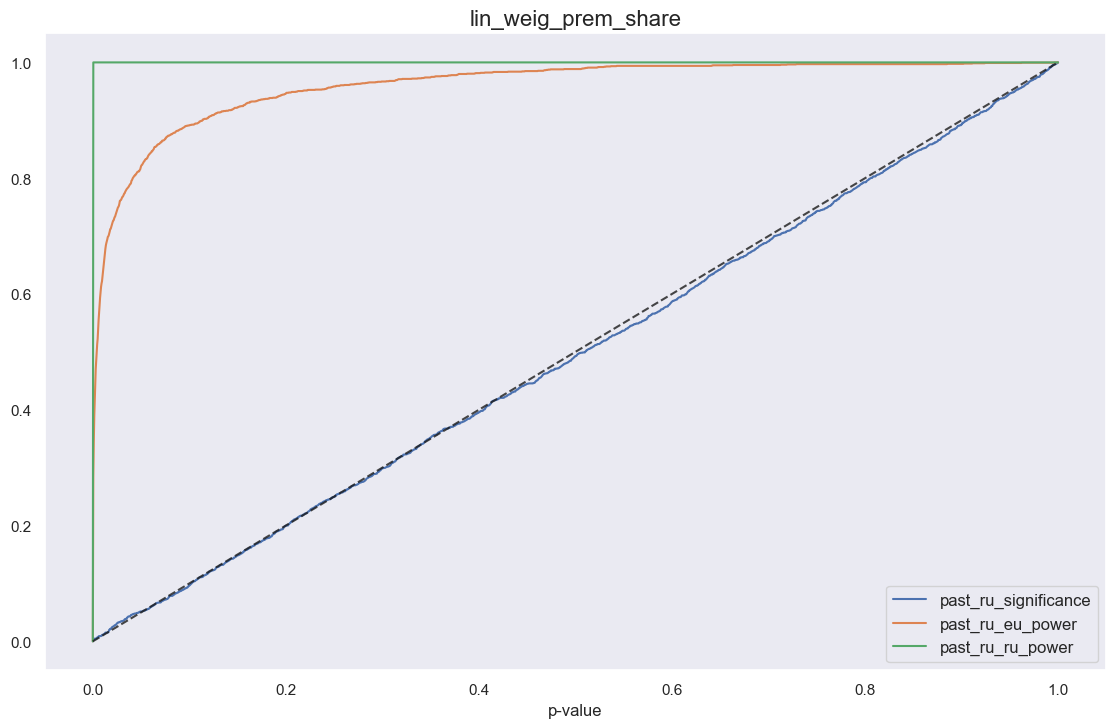

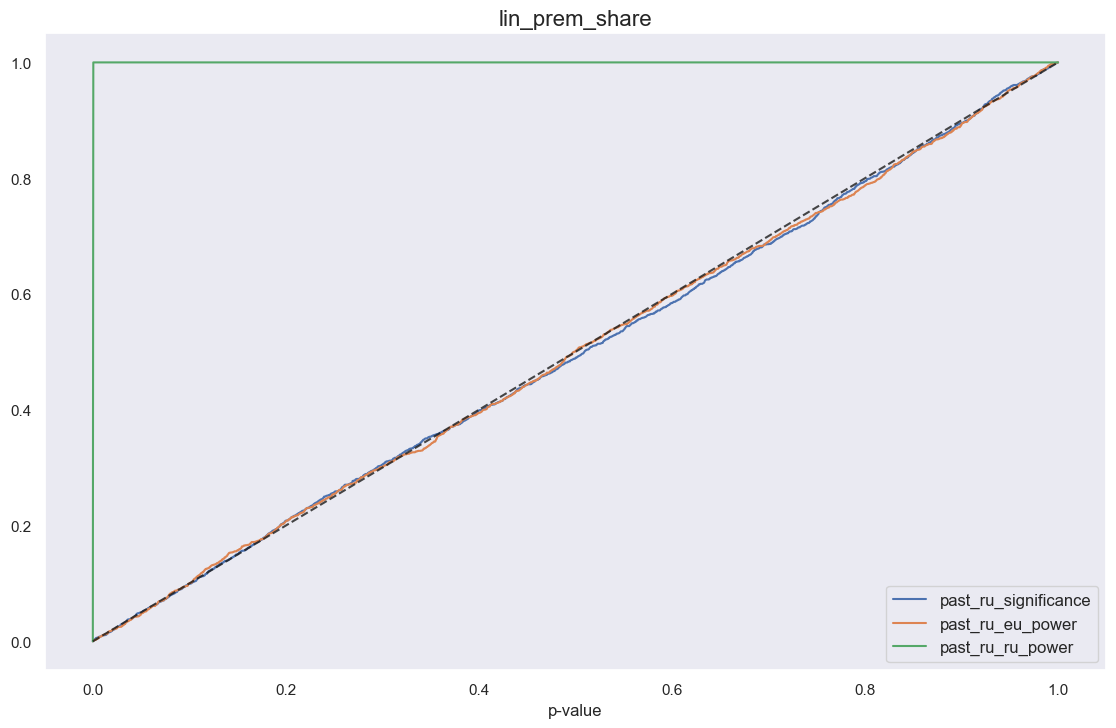

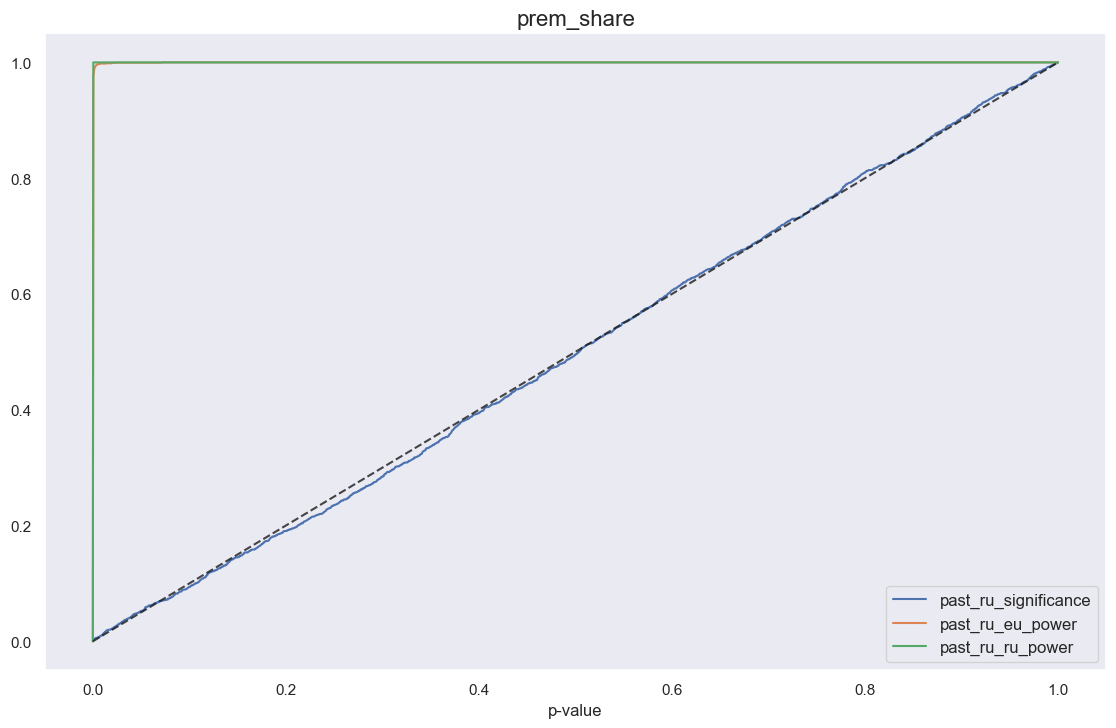

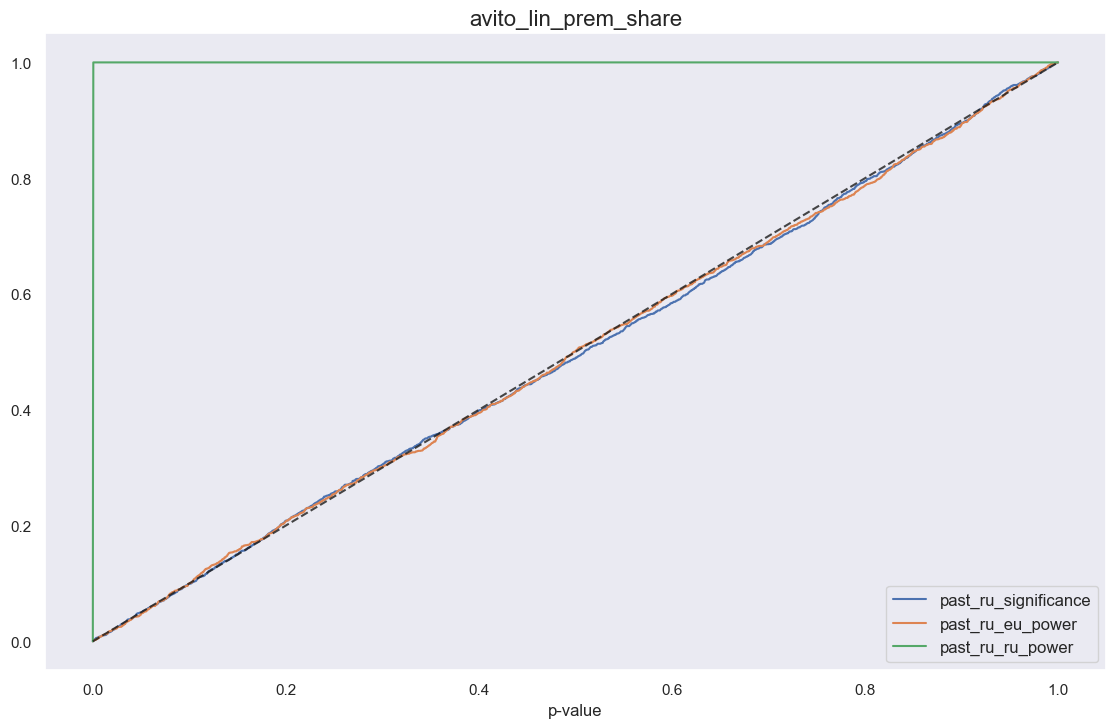

In [12]:
plot_pvalue_distribution(df_prem_share_stats[['lin_weig_prem_share', 'title']])
plot_pvalue_distribution(df_prem_share_stats[['lin_prem_share', 'title']])
plot_pvalue_distribution(df_prem_share_stats[['prem_share', 'title']])
plot_pvalue_distribution(df_prem_share_stats[['avito_lin_prem_share', 'title']])
plt.show()

Для всех метрик симулированный уровень альфа не отклоняется от установленного истинного - значит ни одна из метрик не завышает ошибку первого рода

Различия между past_ru и ru оказались настолько большими, что все метрики без труда показали мощность теста близкой к 1, то есть вероятность ошибки второго рода крайне мала при сравнении групп с похожим lift

Самая красивая картинка конечно нарисовалась у взвешенной линеаризованной метрики Яндекса - гипербола со страниц учебников, когда нужно выбирать между уровнем альфа, мощностью теста и его длительностью. К слову мощность неплохая, при альфа = 0.05 бета = 0.8 примерно

Ужасно показали себя невзвешенная метрика Яндекса и Авито, нужна выборка больше. А вот неправильная метрика Среднего средних идеальна до страшного

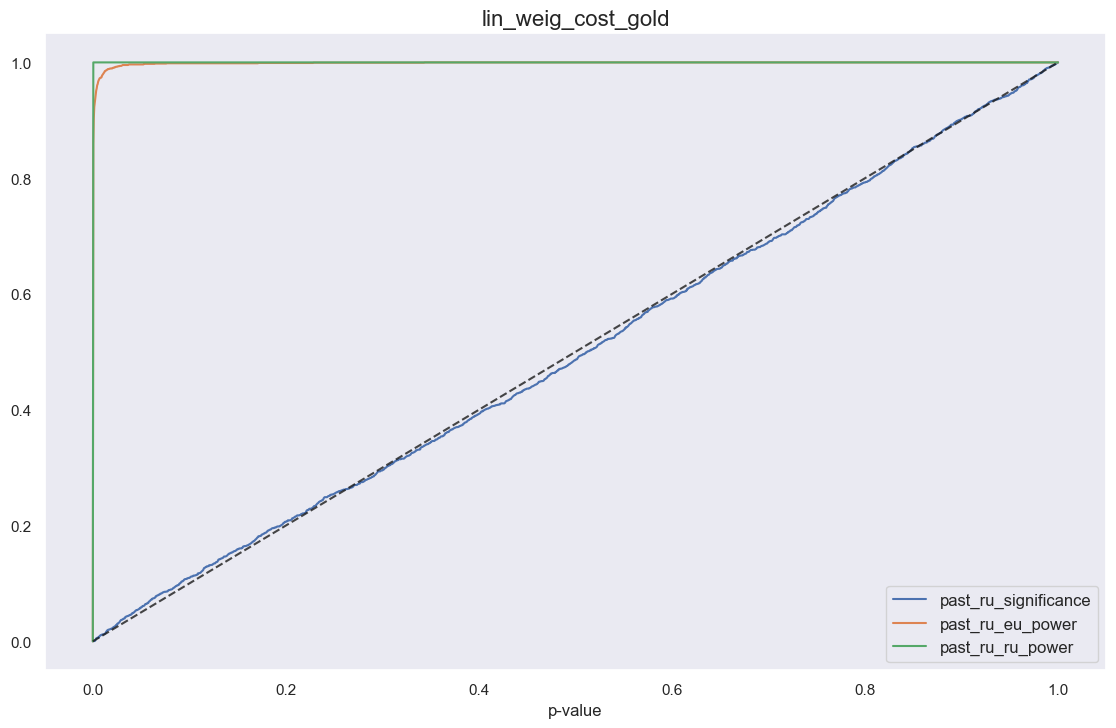

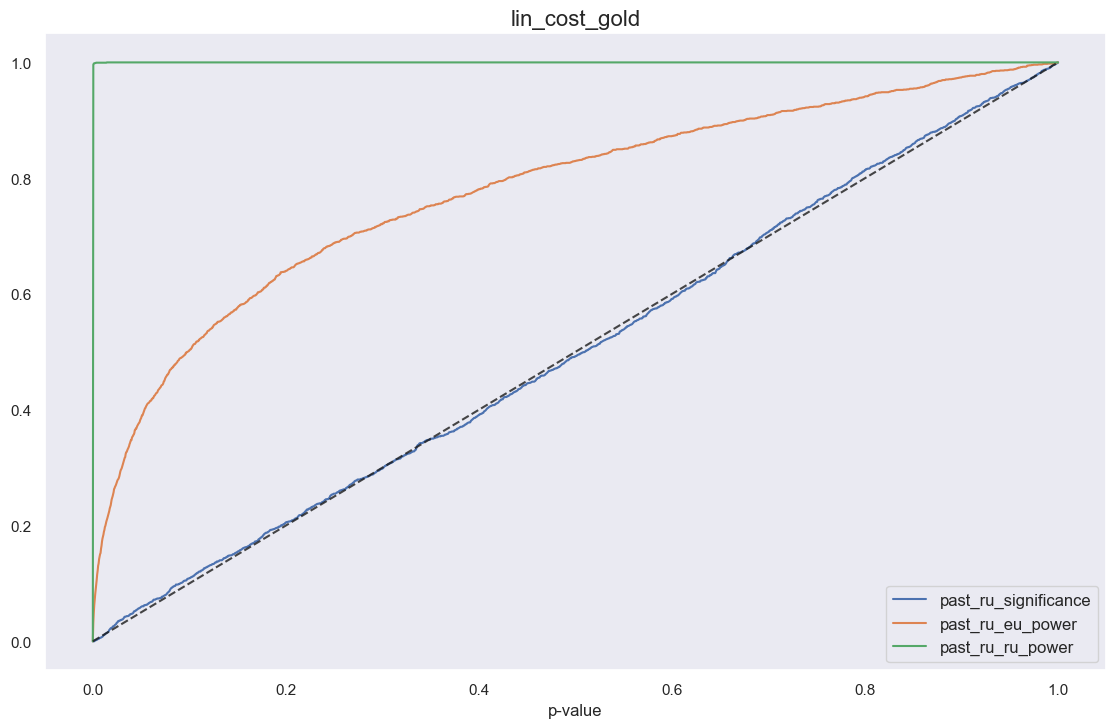

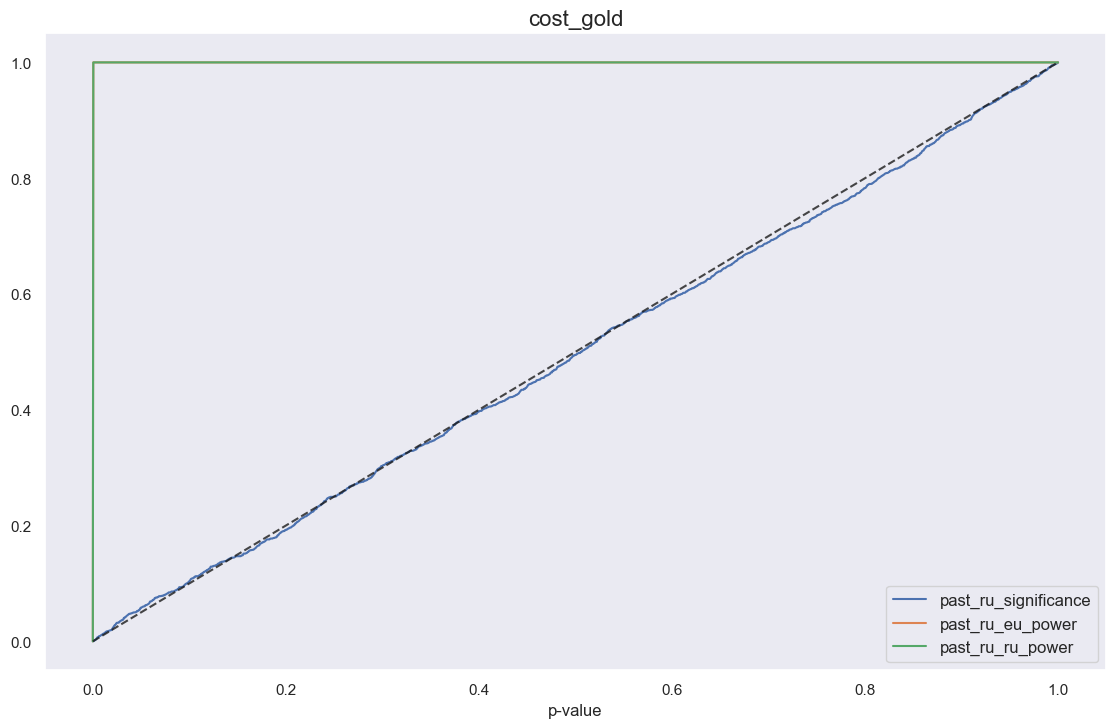

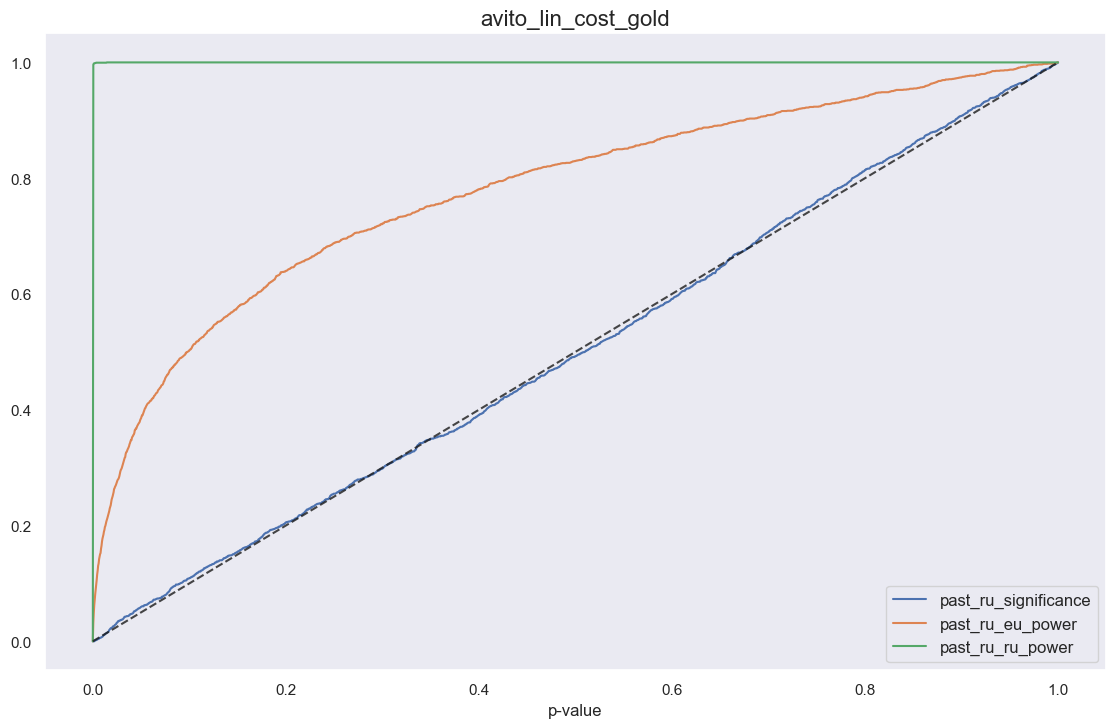

In [14]:
plot_pvalue_distribution(df_cost_gold_stats[['lin_weig_cost_gold', 'title']])
plot_pvalue_distribution(df_cost_gold_stats[['lin_cost_gold', 'title']])
plot_pvalue_distribution(df_cost_gold_stats[['cost_gold', 'title']])
plot_pvalue_distribution(df_cost_gold_stats[['avito_lin_cost_gold', 'title']])
plt.show()

Здесь остановимся лишь на мощности теста past_ru_eu - в средней стоимости танка (неким аналогом ARPU) больше разрыв между новыми русскими и евро, прошлые ру игроки не только покупали больше прем техники в среднем, но приобретали более дорогую. Тут мощность теста гораздо лучше prem_share, но бета у авито и нелинеаризованной яндекса все еще не дотягивает до заветных 0.8

Изучим статистику в разрезе игровой техники

In [525]:
qu_tanks_eu_stats = """
select
    players_eu_tanks.tank_id as tank_id, name, nation, type, tier, sum(wins) as Wins, sum(wins)/sum(battles) as Winrate, sum(battles) as Battles,
    sum(damage_dealt)/sum(damage_received) as Damage_ratio, sum(frags)/sum(battles-survived_battles) as KDR,
    sum(damage_dealt)/sum(battles) as DPB, sum(frags)/sum(battles) as KPB, sum(hits)/sum(battles) as HitsPB,
    sum(hits)/sum(shots) as HitRate, cost_gold
from players_eu_tanks join (select tank_id, tier, cost_gold, name, nation, type from tanks) r on players_eu_tanks.tank_id=r.tank_id
where battles > 0
group by tank_id, tier, cost_gold, name, nation, type
order by Battles desc
"""
qu_tanks_eu_ownership = """
with (select uniq(account_id) from players_eu_tanks) as num_acc
select tank_id, count(account_id)/num_acc as owners_share, count(account_id) as owners
from players_eu_tanks
group by tank_id
"""
df_tanks_eu_stats = ph.read_clickhouse(query=qu_tanks_eu_stats, connection=connection_default)
df_tanks_eu_ownership = ph.read_clickhouse(query=qu_tanks_eu_ownership, connection=connection_default)

In [526]:
df_tanks_eu_stats = df_tanks_eu_stats.merge(df_tanks_eu_ownership, how='inner', on='tank_id')
df_tanks_eu_stats['Defeats'] = df_tanks_eu_stats['Battles'] - df_tanks_eu_stats['Wins']

In [527]:
df_tanks_eu_stats.head(5)

,tank_id,name,nation,type,tier,Wins,Winrate,Battles,Damage_ratio,KDR,DPB,KPB,HitsPB,HitRate,cost_gold,owners_share,owners,Defeats
0,10497,KV-2,ussr,heavyTank,6,16050697,0.502631,31933383,1.185420,1.283999,877.118974,0.854665,2.531927,0.724973,0,0.374259,171750,15882686
1,2817,KV-1S,ussr,heavyTank,6,15030554,0.498786,30134291,1.032101,1.066769,827.279923,0.718399,3.667390,0.781311,0,0.460102,211144,15103737
2,5393,VK 16.02 Leopard,germany,lightTank,5,14989437,0.500476,29950381,0.925839,0.899880,510.978698,0.661809,32.165725,0.689723,0,0.546008,250567,14960944
3,5137,Tiger II,germany,heavyTank,8,13904841,0.484544,28696771,0.845317,0.939886,1199.967631,0.631347,5.701963,0.825969,0,0.357706,164154,14791930
4,11777,KV-1,ussr,heavyTank,5,14501615,0.509311,28472983,1.091639,1.212170,623.099892,0.778438,5.108829,0.771669,0,0.671275,308053,13971368


Топ 10 танков по винрейту

In [473]:
df_tanks_eu_stats[['name', 'tier', 'Battles', 'Winrate', 'owners_share']]\
    .sort_values('Winrate', ascending=False).head(10)

,name,tier,Battles,Winrate,owners_share
530,IS-6 Fearless,8,15641,0.713637,0.000588
493,Type 98 Ke-Ni Otsu,3,280900,0.686091,0.000898
531,Lorraine 40 t Fearless,8,6502,0.657798,0.000451
460,KV-220 Beta-Test,5,464817,0.613043,0.010978
481,Pz.Kpfw. II Ausf. J,3,344695,0.610844,0.017498
483,CS-52 LIS,7,337721,0.597348,0.026559
407,SU-76I,3,973055,0.597244,0.037807
514,Pz.Kpfw. 38H 735 (f),2,153445,0.592701,0.015600
139,Dracula,7,5428755,0.588952,0.043268
123,Smasher,7,5942661,0.582721,0.044554


Топ 10 танков по популярнсти

In [475]:
df_tanks_eu_stats[['name', 'tier', 'Battles', 'Winrate', 'owners_share']]\
    .sort_values('owners_share', ascending=False).head(10)

,name,tier,Battles,Winrate,owners_share
98,BT-7,3,7174778,0.541413,0.739433
59,Pz.Kpfw. III,3,10130921,0.563788,0.732416
30,A-20,4,14313922,0.525740,0.729021
38,Pz.Kpfw. IV Ausf. D,4,13105678,0.517921,0.707244
225,BT-2,2,3317294,0.566341,0.671981
4,KV-1,5,28472983,0.509311,0.671275
259,Pz.Kpfw. 35 (t),2,2776316,0.570298,0.666564
150,Pz.Kpfw. II,1,5089216,0.550382,0.654662
15,Pz.Kpfw. IV Ausf. G,5,19859658,0.501258,0.616920
104,M5 Stuart,3,7022806,0.552384,0.613700


Топ 5 веток по популярнсти прокачивания

In [476]:
df_tanks_eu_stats[(df_tanks_eu_stats.tier==10) & (df_tanks_eu_stats.cost_gold==0)]\
    [['name', 'tier', 'Battles', 'Winrate', 'owners_share']]\
    .sort_values('owners_share', ascending=False).head(5)

,name,tier,Battles,Winrate,owners_share
9,E 100,10,24007204,0.497964,0.169487
8,FV215b (183),10,24799615,0.478227,0.113670
18,Grille 15,10,19084799,0.482299,0.111805
27,T57 Heavy Tank,10,15253086,0.497558,0.110380
74,XM551 Sheridan,10,8940136,0.497807,0.109532


Топ 5 премиум танков по популярнсти (8-10 уровень)

In [478]:
df_tanks_eu_stats[(df_tanks_eu_stats.tier>=8) & (df_tanks_eu_stats.cost_gold!=0)]\
    [['name', 'tier', 'Battles', 'Winrate', 'owners_share']]\
    .sort_values('owners_share', ascending=False).head(5)

,name,tier,Battles,Winrate,owners_share
36,Löwe,8,13196601,0.506018,0.119048
32,IS-6,8,13989218,0.527457,0.104256
84,IS-5 (Object 730),8,8402230,0.529348,0.095553
96,T26E4 SuperPershing,8,7374365,0.506993,0.088297
88,T34,8,8060764,0.510952,0.076541


Матрица корреляции признаков танков

<Axes: >

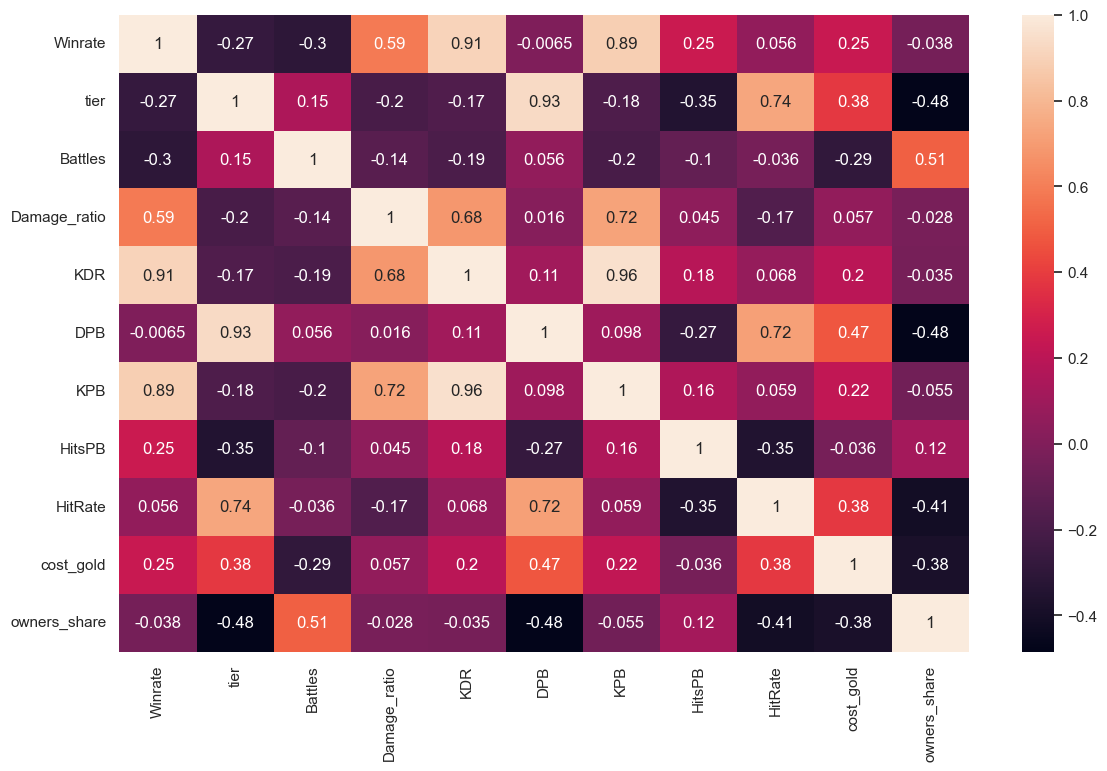

In [477]:
sns.heatmap(df_tanks_eu_stats[['Winrate', 'tier', 'Battles', 'Damage_ratio', 'KDR', 'DPB',
                               'KPB', 'HitsPB', 'HitRate', 'cost_gold', 'owners_share']].corr(),
            annot=True)

Процент побед коррелирует с KDR(kill to death ratio) и KPB(kills per battle), но в этом ничего удивительно - причина победы в матче практически наверняка - уничтожение всей техники противника, тут показатель KDR прямо зависит и в числителе победа=> уничтожили всю технику, и в знаменателе - при победе шанс остаться в живых выше в разы, соотвественно, умереть ниже, то есть числитель растет, в то время как знаменатель падает при победе.
В то же время Hit rate (процент попаданий от всех выстрелов) и DPB(damage per battle) и особенно уровень техники показали отрицательную корреляцияю с процентом побед - с уровнем техники растет запас ее прочности, то есть средний урон за битву растет однозначно (что отражает коэф корреляции = 0,93). Также с повышением уровня техники растут навыки игрока, так как он проводит в игре некоторе время чтобы получить более высокий уровень техники, что прежде всего отражается в улучшении точности стрельбы (одна из базовых и простых механик, коэф корр = 0,74). Тем не менее на высоких уровня цена ошибки высока, коэф корр между уровнем техники и процентом побед = -0,48 - на высоких уровнях играют опытные игроки, в таких сражениях недостаточно хороших показателей стрельбы, также требуется понимание карт и позиций, более глубоких механик игры.
Стоимость техники за золото (реальные деньги) отрицательно (-0.38) коррелирует с относительным количеством аккаунтов, владеющими данной техникой. Интересно узнать зависимость цены и спроса

Коэффициенты корреляции Спирмена также показали схожие значения и оказались стат значимыми

In [514]:
print(stats.spearmanr(df_tanks_eu_stats['HitRate'], df_tanks_eu_stats['tier']))
print(stats.spearmanr(df_tanks_eu_stats['cost_gold'], df_tanks_eu_stats['owners']))

SignificanceResult(statistic=0.7492908462544774, pvalue=6.351090785065688e-97)
SignificanceResult(statistic=-0.6680143986395222, pvalue=4.9357226722760864e-70)


Построим линейную регрессию для исследования связи cost_gold и owners

In [507]:
linear_data = np.log(df_tanks_eu_stats[df_tanks_eu_stats.cost_gold>0][['owners', 'cost_gold']])
res = stats.linregress(x=linear_data['cost_gold'], y=linear_data['owners'])

LinregressResult(slope=-0.22902511467909778, intercept=11.574467439604383, rvalue=-0.41287105347911474, pvalue=4.067669855152455e-13, stderr=0.03008583917652167, intercept_stderr=0.23189872888571839)
R2 = 0.170462506800954


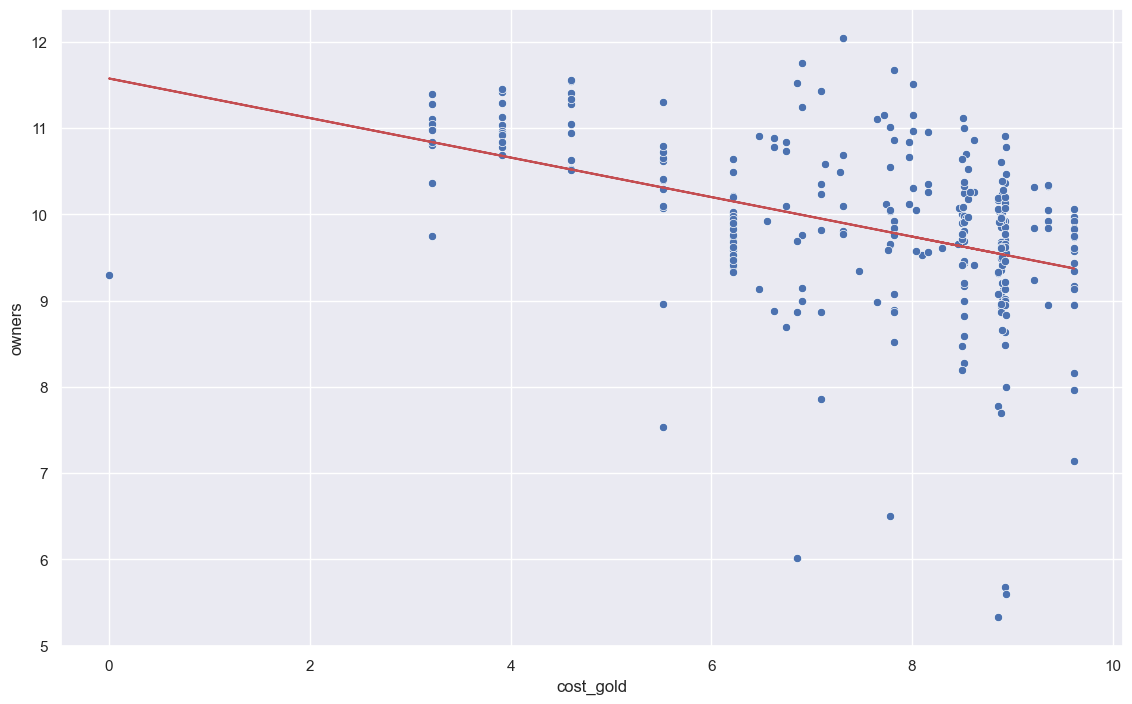

In [511]:
sns.scatterplot(data=linear_data, x="cost_gold", y="owners")
plt.plot(linear_data['cost_gold'], res.intercept + res.slope*linear_data['cost_gold'], 'r', label='fitted line')
print(res)
print('R2 = '+str(res[2]**2))

качество модели плохое - цена в золоте объясняет лишь 17% изменчивости целевой переменной спроса на товар, тем не менее выбранный показатель значимо влияет на объем спроса - pvalue коэффициента гораздо меньше 0.
Так как обе велечины были прологарифмированы, то коэф slope по сути является показателем эластичности спроса по цене - при изменении цены на 1%, спрос в среднем Упадет на 0.23%, то есть спрос неэластичен и компании выгодно повышать цену на технику в золоте, либо цену золота в рублях.

In [518]:
df_type_lvl_win = df_tanks_eu_stats.query('tier>4').groupby(['type', 'tier'])['Winrate'].mean().reset_index()
tier_type_pivot = pd.pivot_table(data=df_type_lvl_win, index='type', columns='tier', values='Winrate')
tier_type_pivot['mean'] = df_tanks_eu_stats.query('tier>4').groupby(['type'])['Winrate'].mean()
tier_type_pivot

tier,5,6,7,8,9,10,mean
type,,,,,,,
AT-SPG,0.511410,0.508230,0.506151,0.501368,0.510254,0.504814,0.506192
heavyTank,0.525066,0.517724,0.520876,0.524589,0.512041,0.509184,0.519087
lightTank,0.503192,0.508619,0.512320,0.496436,0.519403,0.508044,0.507764
mediumTank,0.524311,0.512813,0.511453,0.514185,0.496408,0.510072,0.513176


Показатель процента побед падает с ростом уровня на всех типах техники, но на тяжелых такнках он постоянно держится выше

Text(0.5, 1.0, 'Процент побед в зависимости от типа техники')

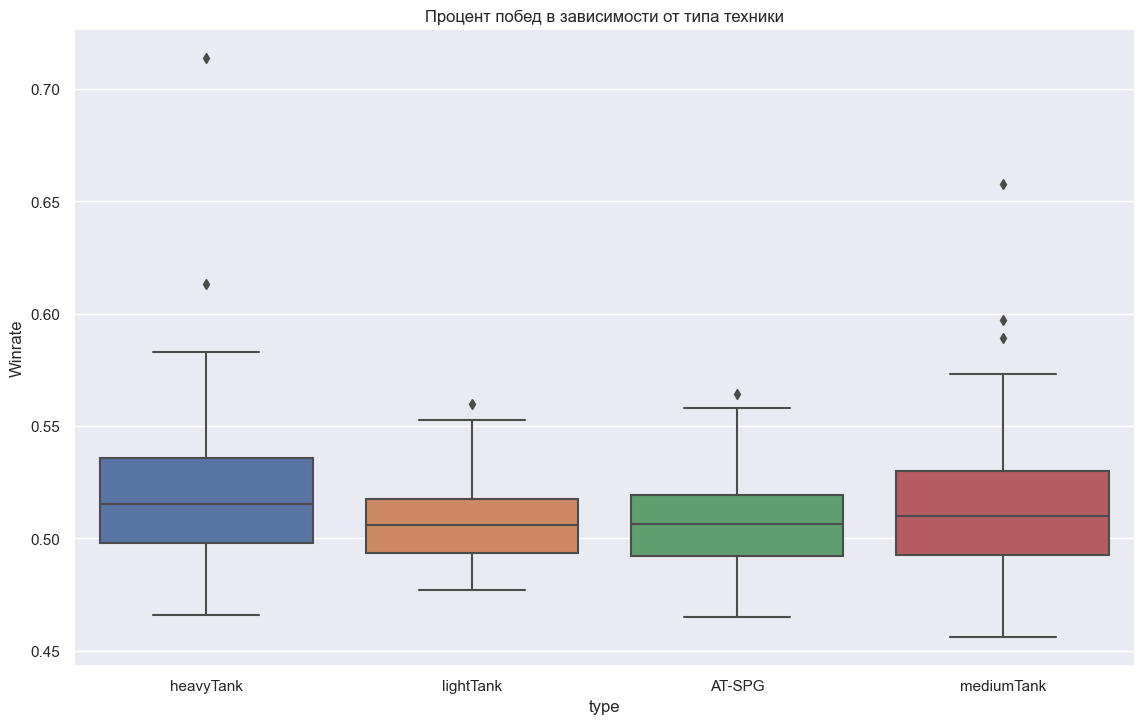

In [520]:
sns.boxplot(x = 'type', y = 'Winrate', data = df_tanks_eu_stats[df_tanks_eu_stats.tier>4])
plt.title('Процент побед в зависимости от типа техники')

In [545]:
print('(AT-SPG - heavyTank pvalue = )' + str(
        ttest_ind(df_tanks_eu_stats.query('tier>4')[df_tanks_eu_stats.type=='AT-SPG']['Winrate'].values, 
        df_tanks_eu_stats.query('tier>4')[df_tanks_eu_stats.type=='heavyTank']['Winrate'].values,
        equal_var=False)[1]))
print('(lightTank - heavyTank pvalue = )' + str(
        ttest_ind(df_tanks_eu_stats.query('tier>4')[df_tanks_eu_stats.type=='lightTank']['Winrate'].values, 
        df_tanks_eu_stats.query('tier>4')[df_tanks_eu_stats.type=='heavyTank']['Winrate'].values,
        equal_var=False)[1]))
print('(mediumTank - heavyTank pvalue = )' + str(
        ttest_ind(df_tanks_eu_stats.query('tier>4')[df_tanks_eu_stats.type=='mediumTank']['Winrate'].values, 
        df_tanks_eu_stats.query('tier>4')[df_tanks_eu_stats.type=='heavyTank']['Winrate'].values,
        equal_var=False)[1]))

(AT-SPG - heavyTank pvalue = )0.00010296722514437011
(lightTank - heavyTank pvalue = )0.0033311382978058112
(mediumTank - heavyTank pvalue = )0.09145201635185642


Даже с поправкой Бонферонни на множественное тестирование, при которой alpha = 0.016 при изначальной alpha = 0.05, тяжелые танки стат значимо имеют более высокий уровень побед, по сравнению с легкими и ПТ-САУ. Можно визуально удостовериться в этом на pointplot

Text(0.5, 1.0, 'Процент побед в зависимости от типа техники')

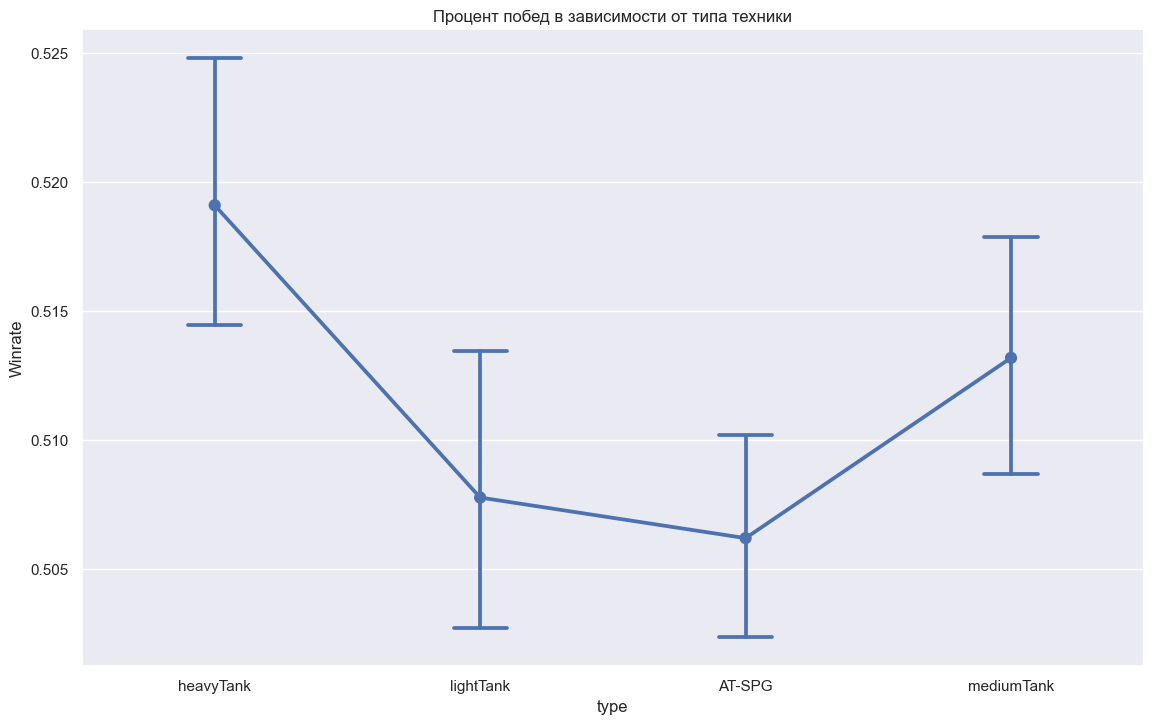

In [546]:
sns.pointplot(x = 'type', y = 'Winrate', data = df_tanks_eu_stats[df_tanks_eu_stats.tier>4], capsize = .2)
plt.title('Процент побед в зависимости от типа техники')

Посмотрим на метрики MAU

In [572]:
qu_MAU = """
SELECT Y_M_last as time, (SUM(regs - last) over (order by Y_M_last))+regs as MAU, regs, last
FROM
(SELECT
    date_trunc('month', created_at) AS Y_M_cretaed,
    COUNT(account_id) AS regs
FROM players
WHERE battles>500
GROUP BY Y_M_cretaed) AS l
LEFT OUTER JOIN
(SELECT
    date_trunc('month', last_battle_time) AS Y_M_last,
    COUNT(account_id) AS last
FROM players
WHERE battles>500
GROUP BY Y_M_last) AS r
ON l.Y_M_cretaed = r.Y_M_last
where Y_M_last!=date_trunc('month', toDateTime('1970-01-01'))
"""
df_MAU = ph.read_clickhouse(query=qu_MAU, connection=connection_default)
df_churn_dist = ph.read_clickhouse(query=qu_churn_dist, connection=connection_default)

Text(0.5, 1.0, 'MAU у кого > 500 боев')

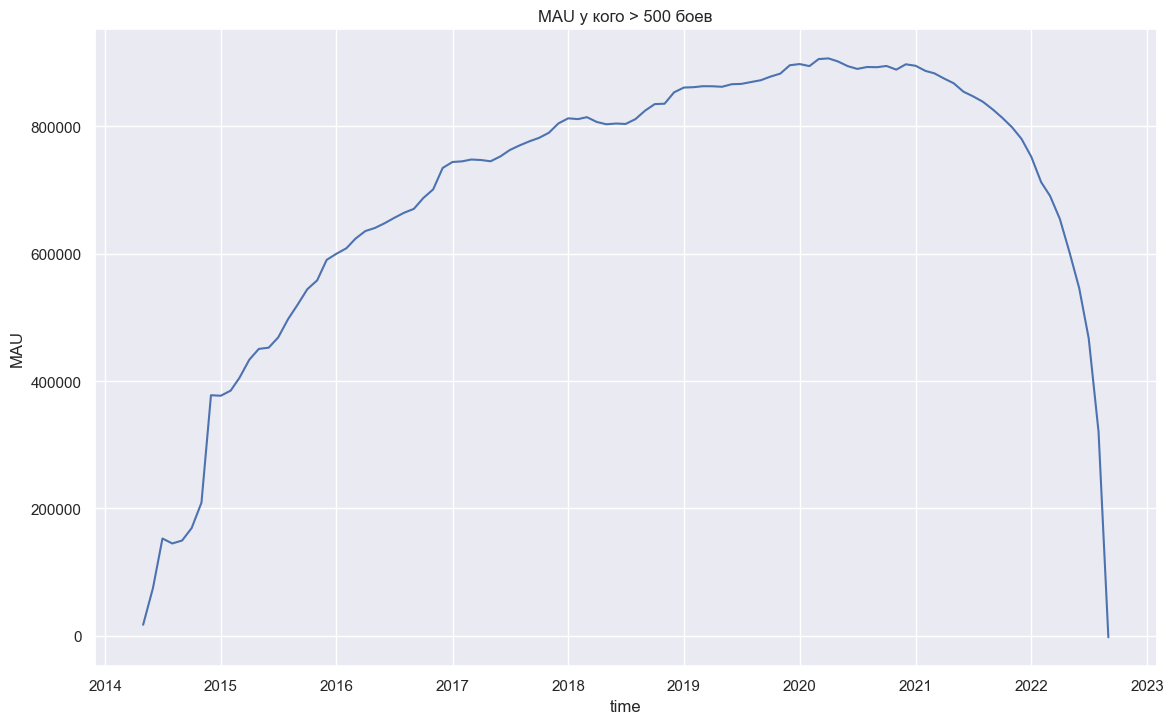

In [580]:
sns.lineplot(data=df_MAU, x='time', y='MAU')
plt.title('MAU у кого > 500 боев')

Text(0.5, 1.0, 'регистрации и отток, > 500 боев')

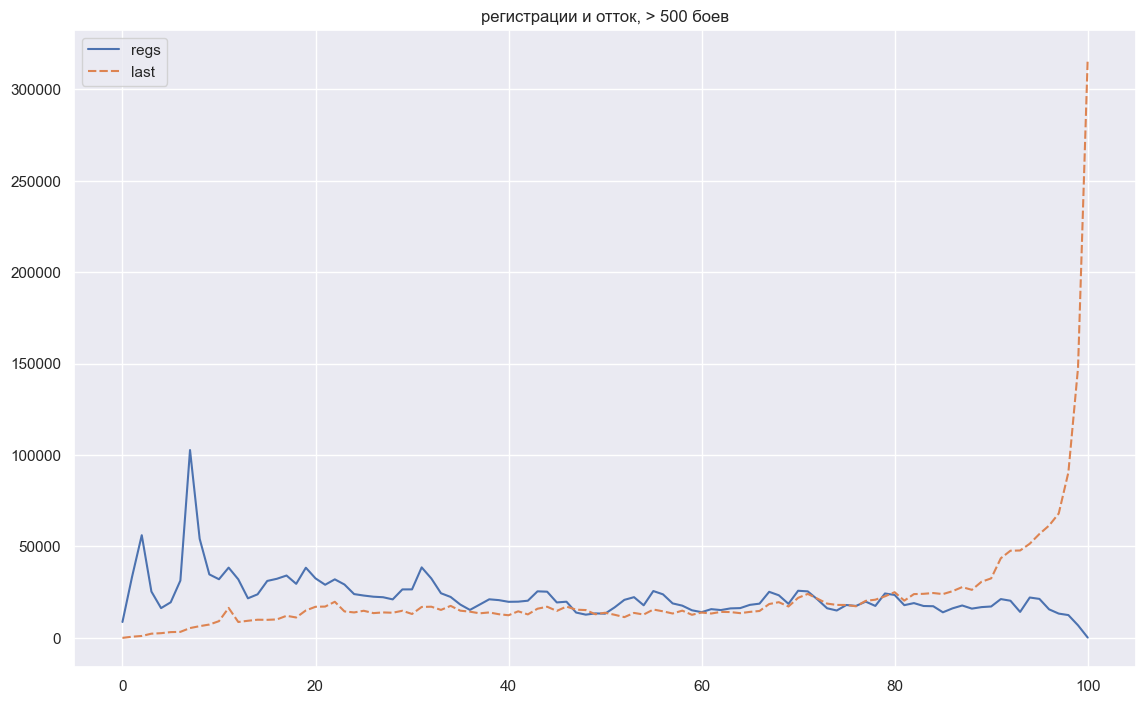

In [581]:
sns.lineplot(data=df_MAU[['time', 'regs', 'last']])
#sns.lineplot(data=df_MAU, x='time', y='last')
plt.title('регистрации и отток, > 500 боев')

Text(0.5, 1.0, 'MAU у кого > 500 боев, до 2021-09-01')

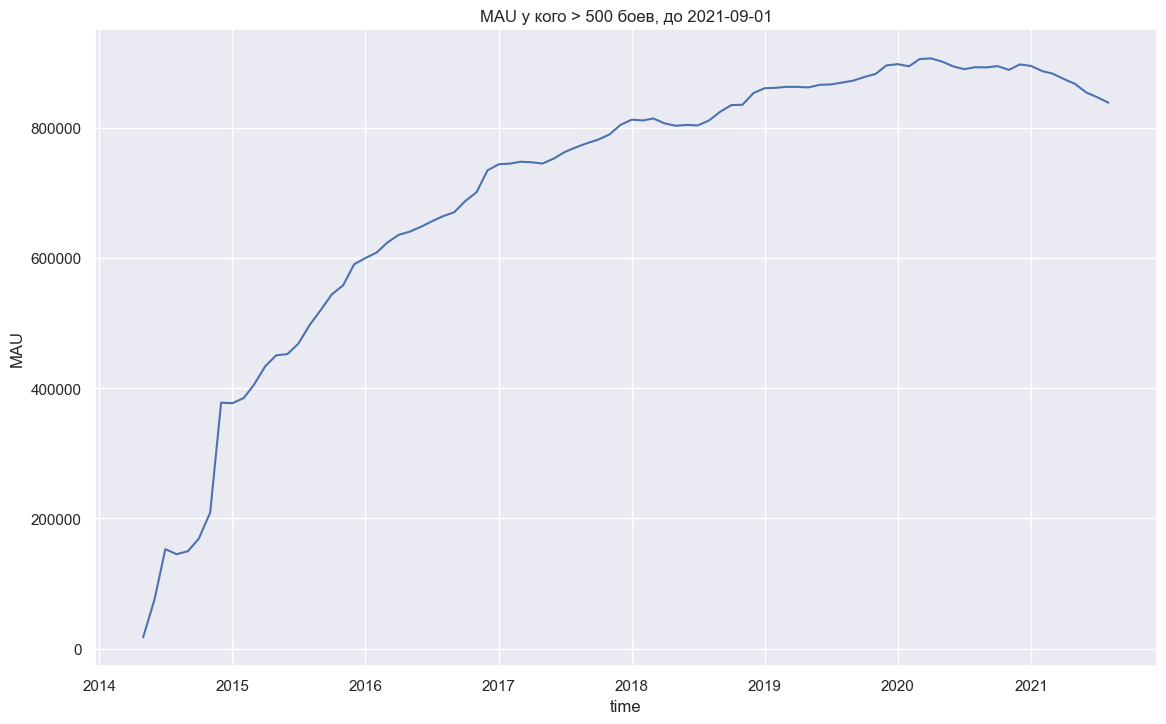

In [583]:
sns.lineplot(data=df_MAU[df_MAU.time<'2021-09-01'], x='time', y='MAU')
plt.title('MAU у кого > 500 боев, до 2021-09-01')

MAU заметно проседает после сентября 2021 - это из-за расчета метрики через
(зарегестрированные аккаунты в прошлом месяце - кол-во аккаунтов, у кторых last_battle_time был в прошлом месяце) + зарегестрированные аккаунты в текущем месяце, по другому нельзя, так как нет данных о ежедневной активности игроков. Учитвая, что данные собраны в сентябре-октябре 2022, то игроки могут в течении года не заходить в игру, но потом все-таки возвращаться